In [ ]:
# @title Шаг 1: Установка библиотек и настройка Kaggle API

# Устанавливаем все необходимые библиотеки
!pip install wfdb -q
!pip install biosppy -q
!pip install peakutils -q
!pip install kaggle -q

# Импортируем все необходимое
import os, wfdb, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, ast
from scipy import signal as scisignal
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import files
from wfdb.processing import gqrs_detect

# Загрузка Kaggle API ключа
print("Пожалуйста, загрузите ваш файл kaggle.json")
# При выполнении появится кнопка для загрузки файла.
# Выберите файл kaggle.json, который вы скачали ранее.
files.upload()

# Настройка Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nKaggle API успешно настроен.")

Пожалуйста, загрузите ваш файл kaggle.json


Saving kaggle.json to kaggle (1).json

Kaggle API успешно настроен.


In [ ]:
# @title Шаг 2: Загрузка и обработка MIT-BIH

# Определяем глобальные переменные для классов
aami_classes = ['N', 'S', 'V', 'F', 'Q']
class_to_int = {c: i for i, c in enumerate(aami_classes)}
aami_map_mitbih = { 'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N', 'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S', 'V': 'V', 'E': 'V', 'F': 'F', '/': 'Q', 'f': 'Q', 'Q': 'Q' }

def load_mitbih_data():
    print("Загрузка и обработка MIT-BIH...")
    wfdb.dl_database('mitdb', dl_dir='mitdb_data')
    records = wfdb.get_record_list('mitdb')
    X, y, pids = [], [], []

    for i, rec_name in tqdm(enumerate(records), total=len(records), desc="Обработка MIT-BIH"):
        record = wfdb.rdrecord(f'mitdb_data/{rec_name}')
        annotation = wfdb.rdann(f'mitdb_data/{rec_name}', 'atr')
        fs = record.fs
        signal_data = np.nan_to_num(record.p_signal[:, 0]) # Используем первое отведение

        r_peaks = annotation.sample # Используем эталонные аннотации для R-пиков

        target_len = 187 # Стандартная длина сегмента
        window_size = int(0.8 * fs)
        half_window = window_size // 2

        for j, r_peak in enumerate(r_peaks):
            # Убеждаемся, что для данного сокращения есть метка в нашем словаре
            if annotation.symbol[j] in aami_map_mitbih:
                # Проверяем границы, чтобы не выйти за пределы сигнала
                if r_peak - half_window >= 0 and r_peak + half_window < len(signal_data):
                    segment = scale(signal_data[r_peak - half_window : r_peak + half_window])
                    resized_segment = np.interp(np.linspace(0, 1, target_len), np.linspace(0, 1, len(segment)), segment)
                    X.append(resized_segment)
                    y.append(class_to_int[aami_map_mitbih[annotation.symbol[j]]])
                    pids.append(i) # i - это уникальный ID пациента

    return np.array(X), np.array(y), np.array(pids)

X_mitbih, y_mitbih, pids_mitbih = load_mitbih_data()
print(f"MIT-BIH: Загружено {len(X_mitbih)} сокращений.")

Загрузка и обработка MIT-BIH...
Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generati

Обработка MIT-BIH:   0%|          | 0/48 [00:00<?, ?it/s]

MIT-BIH: Загружено 109445 сокращений.


In [ ]:
# @title Шаг 3 (Финальная рабочая версия): Загрузка и обработка PTB-XL

# Загружаем датасет, если его еще нет
data_dir_kaggle = 'ptb_xl_data_kaggle'
if not os.path.exists(data_dir_kaggle):
    !kaggle datasets download -d khyeh0719/ptb-xl-dataset -p {data_dir_kaggle} --unzip
else:
    print("Данные PTB-XL с Kaggle уже существуют.")

# Определяем пути к файлам
data_root_path = os.path.join(data_dir_kaggle, 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1')
path_metadata = os.path.join(data_root_path, 'ptbxl_database.csv')

# Импортируем детектор из biosppy
from biosppy.signals import ecg

def load_ptbxl_data(start_pid):
    print("Обработка данных PTB-XL...")
    Y = pd.read_csv(path_metadata, index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    scp_map_ptbxl = { 'NORM': 'N', 'MI': 'Q', 'STTC': 'Q', 'CD': 'Q', 'HYP': 'Q', 'SVPB': 'S', 'PVC': 'V', 'AFIB': 'S' }

    X, y, pids = [], [], []

    for ecg_id, row in tqdm(Y.iterrows(), total=len(Y), desc="Обработка PTB-XL"):
        try:
            # Правильно определяем путь к файлу
            if 'filename_hr' in row and pd.notna(row['filename_hr']):
                file_path = os.path.join(data_root_path, row['filename_hr'])
            elif 'filename_lr' in row and pd.notna(row['filename_lr']):
                file_path = os.path.join(data_root_path, row['filename_lr'])
            else:
                continue

            record = wfdb.rdrecord(file_path)

            # Берем fs из объекта record
            fs = record.fs

            lead_index = 1 if record.p_signal.shape[1] > 1 else 0
            if np.all(np.isnan(record.p_signal[:, lead_index])): continue
            signal_data = np.nan_to_num(record.p_signal[:, lead_index])

            # Используем надежный детектор из biosppy
            segmenter_result = ecg.ecg(signal=signal_data, sampling_rate=fs, show=False)
            r_peaks = segmenter_result['rpeaks']

            if len(r_peaks) == 0:
                continue

            label_class, found_classes = 'Q', {scp_map_ptbxl[code] for code in row.scp_codes.keys() if code in scp_map_ptbxl}
            if 'V' in found_classes: label_class = 'V'
            elif 'S' in found_classes: label_class = 'S'
            elif 'N' in found_classes: label_class = 'N'

            target_len, window_size, half_window = 187, int(0.8 * fs), int(0.4 * fs)

            for r_peak in r_peaks:
                if r_peak - half_window >= 0 and r_peak + half_window < len(signal_data):
                    segment = scale(signal_data[r_peak - half_window : r_peak + half_window])
                    resized_segment = np.interp(np.linspace(0, 1, target_len), np.linspace(0, 1, len(segment)), segment)
                    X.append(resized_segment)
                    y.append(class_to_int[label_class])
                    pids.append(start_pid + row['patient_id']) # Правильный доступ к patient_id

        except Exception as e:
            # print(f"Пропущена запись {ecg_id} из-за ошибки: {e}") # Можно раскомментировать для отладки
            continue

    return np.array(X), np.array(y), np.array(pids)

# Начинаем нумерацию пациентов PTB-XL с числа, следующего за последним пациентом MIT-BIH
X_ptbxl, y_ptbxl, pids_ptbxl = load_ptbxl_data(start_pid=len(np.unique(pids_mitbih)))
print(f"PTB-XL: Загружено {len(X_ptbxl)} сокращений.")

Данные PTB-XL с Kaggle уже существуют.
Обработка данных PTB-XL...


Обработка PTB-XL:   0%|          | 0/21837 [00:00<?, ?it/s]

PTB-XL: Загружено 248342 сокращений.


Всего сокращений для обучения: 357787 от 18933 пациентов.


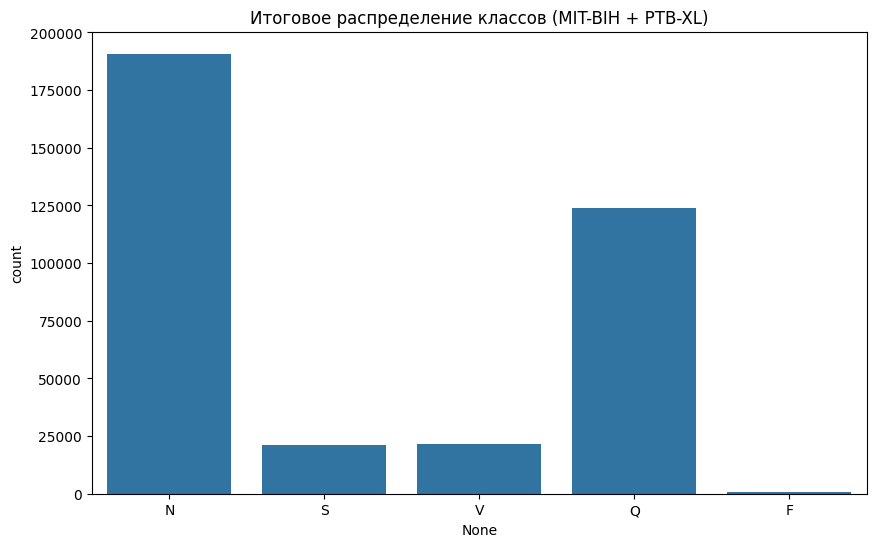

Размер обучающей выборки: 220885
Размер валидационной выборки: 55222
Размер тестовой выборки: 81680


In [ ]:
# @title Шаг 4: Объединение датасетов и подготовка к обучению

# Объединяем данные
X_full = np.concatenate((X_mitbih, X_ptbxl), axis=0)
y_full = np.concatenate((y_mitbih, y_ptbxl), axis=0)
pids_full = np.concatenate((pids_mitbih, pids_ptbxl), axis=0)

print(f"Всего сокращений для обучения: {len(X_full)} от {len(np.unique(pids_full))} пациентов.")

# Визуализация итогового распределения
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_full).map(lambda i: aami_classes[i])).set(title='Итоговое распределение классов (MIT-BIH + PTB-XL)')
plt.show()

# Разделение по пациентам (стратифицированное по пациентам)
unique_pids = np.unique(pids_full)
train_val_pids, test_pids = train_test_split(unique_pids, test_size=0.2, random_state=42)

train_val_indices = np.isin(pids_full, train_val_pids)
test_indices = np.isin(pids_full, test_pids)

X_train_val, y_train_val = X_full[train_val_indices], y_full[train_val_indices]
X_test, y_test = X_full[test_indices], y_full[test_indices]

# Разделение на обучающую и валидационную выборки (стратифицированное по классам)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Финальная подготовка данных для модели
X_train, X_val, X_test = X_train[..., np.newaxis], X_val[..., np.newaxis], X_test[..., np.newaxis]
num_classes = len(aami_classes)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
class_weights_dict = {i: w for i, w in enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))}

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")

In [ ]:
# @title Шаг 5: Создание и обучение финальной модели

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, dtype=y_pred.dtype); epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    loss = alpha * tf.pow(1. - y_pred, gamma) * cross_entropy
    return tf.reduce_sum(loss, axis=-1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

def build_model(input_shape, num_classes):
    return Sequential([
        Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=input_shape), BatchNormalization(),
        Conv1D(filters=64, kernel_size=6, activation='relu', padding='same'), BatchNormalization(), MaxPooling1D(2),
        Conv1D(filters=128, kernel_size=6, activation='relu', padding='same'), BatchNormalization(),
        Conv1D(filters=128, kernel_size=6, activation='relu', padding='same'), BatchNormalization(), MaxPooling1D(2),
        Conv1D(filters=256, kernel_size=6, activation='relu', padding='same'), BatchNormalization(),
        Conv1D(filters=256, kernel_size=6, activation='relu', padding='same'), BatchNormalization(), MaxPooling1D(2),
        Flatten(),
        Dense(256, activation='relu'), Dropout(0.5),
        Dense(128, activation='relu'), Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

model = build_model(X_train.shape[1:], num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=focal_loss, metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=256, # Увеличиваем batch_size для большого датасета (понизил до 256 для улучшения результатов точности и потерь)
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 187, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 187, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 93, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 93, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 93, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 93, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 93, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 46, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 46, 256)        │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 46, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,507,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307,845 (8.80 MB)

 Trainable params: 2,306,053 (8.80 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.3796 - loss: 0.2658 - val_accuracy: 0.5575 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 2/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.4768 - loss: 0.1784 - val_accuracy: 0.5774 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 3/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.5659 - loss: 0.1392 - val_accuracy: 0.6332 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 4/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5909 - loss: 0.1261 - val_accuracy: 0.6804 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 5/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.6112 - loss: 0.1204 - val_accuracy: 0.6927 - val_loss: 0.1031 - learning_rate: 0.0010
Epoch 6/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.6392 - loss: 0.1115 - val_accuracy: 0.6921 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 7/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.6493 - l

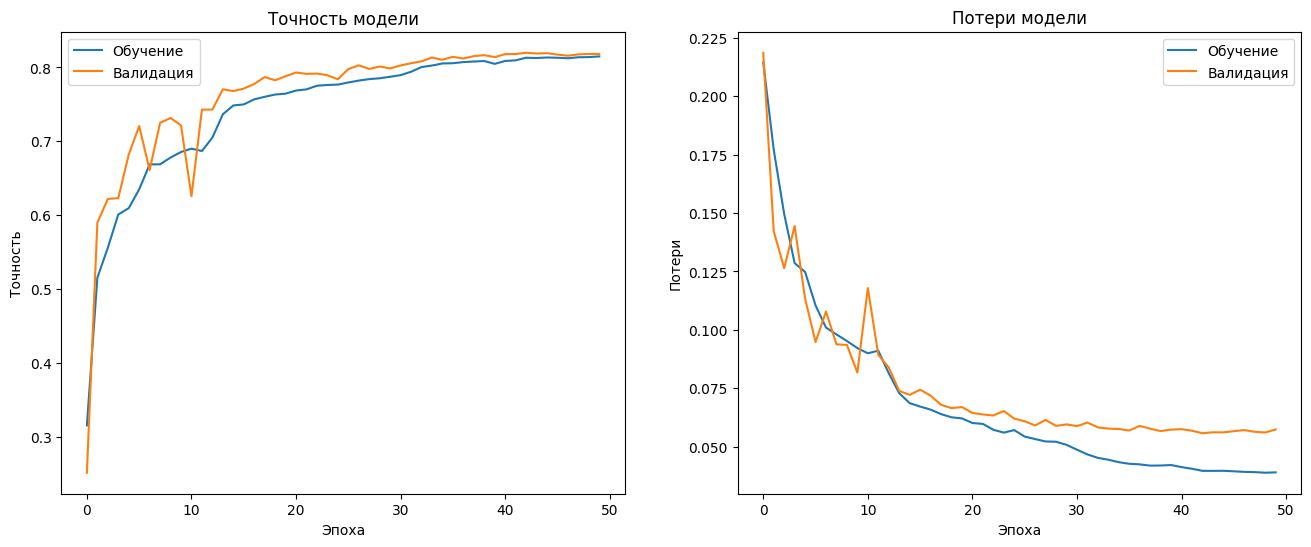

2553/2553 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7596 - loss: 0.1523
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step

Отчет о классификации (тестовая выборка):
              precision    recall  f1-score   support

           N       0.86      0.78      0.82     48189
           S       0.44      0.78      0.56      4124
           V       0.71      0.50      0.58      5730
           F       0.01      0.05      0.02        37
           Q       0.62      0.70      0.65     23600

    accuracy                           0.74     81680
   macro avg       0.53      0.56      0.53     81680
weighted avg       0.76      0.74      0.74     81680



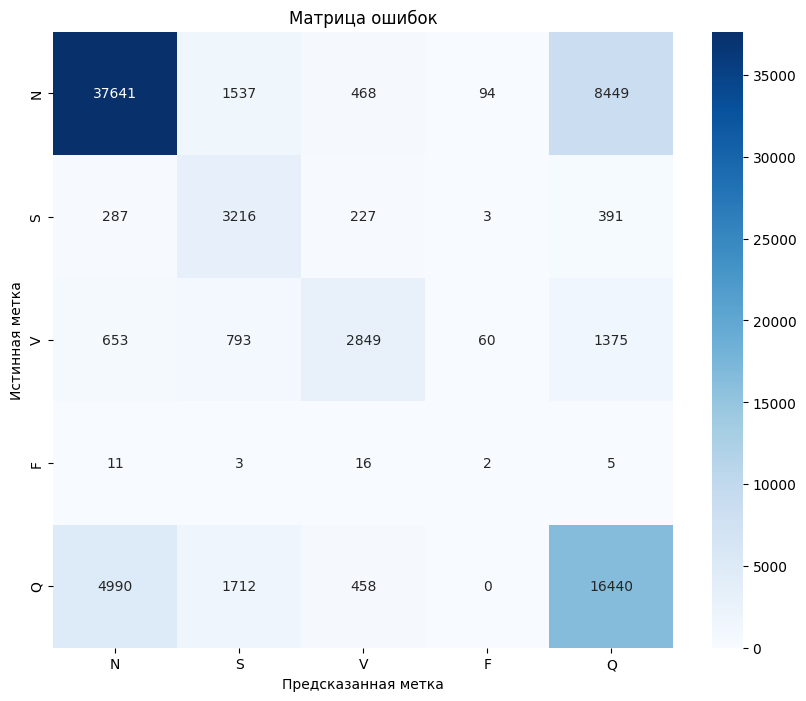

In [ ]:
# @title Шаг 6: Оценка финальной модели

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(history.history['accuracy'], label='Обучение'); ax1.plot(history.history['val_accuracy'], label='Валидация')
    ax1.set_title('Точность модели'); ax1.set_ylabel('Точность'); ax1.set_xlabel('Эпоха'); ax1.legend()
    ax2.plot(history.history['loss'], label='Обучение'); ax2.plot(history.history['val_loss'], label='Валидация')
    ax2.set_title('Потери модели'); ax2.set_ylabel('Потери'); ax2.set_xlabel('Эпоха'); ax2.legend()
    plt.show()

plot_history(history)

model.evaluate(X_test, y_test_cat)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nОтчет о классификации (тестовая выборка):")
print(classification_report(y_test, y_pred, target_names=aami_classes, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=aami_classes, yticklabels=aami_classes)
plt.title('Матрица ошибок'); plt.ylabel('Истинная метка'); plt.xlabel('Предсказанная метка')
plt.show()